# A deterministic surgical tool tip detection algorithm based on segmentation model

## I. Tool tip detection algorithm:


Currently, we are using a ground truth mask instead of a model to focus on the effectiveness of the tool tip determination algorithm, rather than the effectiveness of the segmentation model. However, when we find a good enough segmentation model, we will continue testing.

Our algorithm is a deterministic, training-free algorithm designed to find the tool tip. It is based on skeletonization (using the cv2 library) and employs a graph-based approach, specifically Dijkstra's algorithm.

First of all, let's get acquainted with some concepts:
+ Mask: is an H x W matrix consisting of only pixel 0 (black) and pixel 255 (white) indicating the segmentation of the tool. 
+ Bounding box: is a rectangle $x_1 <= X <= x_2, y_1 <= Y <= y_2$ surrounding the tool. Here the bounding box can be determined through the mask using the formula:
$$
x_1 = \min \left\{ x \mid 0 \le x \le H, \text{ such that there exists } 0 \le y \le W \text{ where } M[x][y] = 255 \right\}
$$
$$
x_2 = \max \left\{ x \mid 0 \le x \le H, \text{ such that there exists } 0 \le y \le W \text{ where } M[x][y] = 255 \right\}
$$
$$
y_1 = \min \left\{ y \mid 0 \le y \le W, \text{ such that there exists } 0 \le x \le H \text{ where } M[x][y] = 255 \right\}
$$
$$
y_2 = \max \left\{ y \mid 0 \le y \le W, \text{ such that there exists } 0 \le x \le H \text{ where } M[x][y] = 255 \right\}
$$

- Abstract edge: We know that a bounding box has four edges. The edges that are close to the boundary (at a distance less than a certain threshold) are called abstract edges. In a bounding box, there are always at most two abstract edges.

- **Handle:** We consider the skeleton matrix $S$ as the set of points $(x,y)$ satisfying $S[x][y] = 255$ (i.e., including the white pixel points). Thus, the handle is the point $s$ belonging to $S$ nearest to the abstract edge of the corresponding bounding box. In the special case where there are two abstract edges, let $A$ be the intersection point of those two abstract edges. Then, the handle is the point $s$ belonging to $S$ nearest to $A$.

- Skeleton graph: To manage the points within the skeleton easily, we construct a graph $ G_S = (V,E) $, where $ V $ represents the set of vertices consisting of points $(x,y)$ satisfying $ S[x][y] = 255 $. If two pixels $ p $ and $ q $ share a common point, we consider them adjacent pixels and add an edge connecting $ p(x_1, y_1) $ and $ q(x_2, y_2) $ to $ E $. Each edge is assigned a weight :

$$ \text{weight}(p,q) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2} $$

Notice that, $|x_1 - x_2| \leq 1, |y_1 - y_2| \leq 1$.


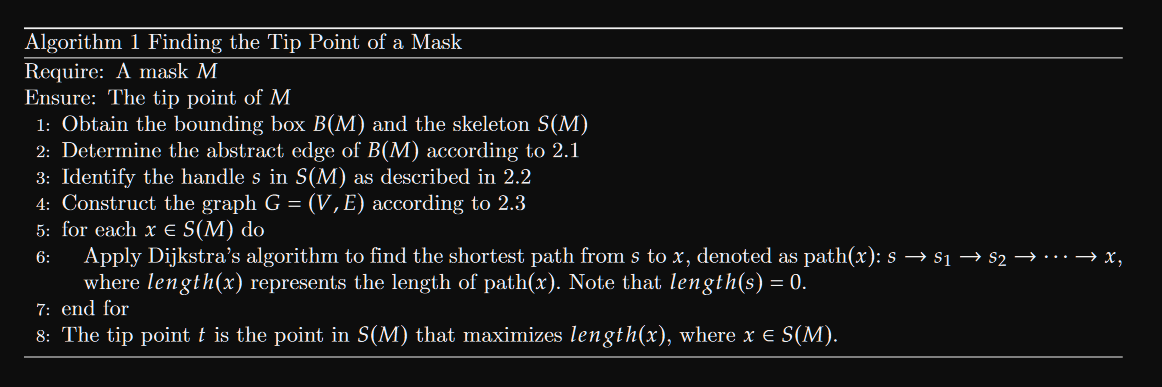

In [4]:
import supervision as sv
from cotracker_utils import *
import networkx as nx

Using cache found in C:\Users\DELL/.cache\torch\hub\facebookresearch_co-tracker_main
Using cache found in C:\Users\DELL/.cache\torch\hub\facebookresearch_co-tracker_main


In [5]:
ROI = [[13, 713], [0, 720]]

In [6]:
class Mask:
    def __init__(self, mask, threshold = 10, white_pixel = 255, crop=True):
        grayscale_image = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        grayscale_image[grayscale_image > threshold] = white_pixel
        self.mask = grayscale_image
        if crop:
            x1 = ROI[0][0]
            x2 = ROI[0][1]
            y1 = ROI[1][0]
            y2 = ROI[1][1]
            self.mask = self.mask[y1:y2, x1:x2]

    def isEmpty(self):
        return np.count_nonzero(self.mask) == 0
    def getSkeleton(self):
        return cv2.ximgproc.thinning(self.mask)
    def getBoundingBox(self):
        if self.isEmpty():
            raise ValueError("Mask is empty")
        else:
            # for all pixels in the mask, if the pixel different than 0, update min_x, max_x, min_y, max_y
            min_x = 999999
            min_y = 999999
            max_x = -999999
            max_y = -999999
            for y in range(len(self.mask)):
                for x in range(len(self.mask[y])):
                    if self.mask[y][x] != 0:
                        min_x = min(min_x, x)
                        min_y = min(min_y, y)
                        max_x = max(max_x, x)
                        max_y = max(max_y, y)
            return (min_x, min_y, max_x, max_y)

In [7]:
class LabModel:
    def __init__(self):
        self.model = InferenceHTTPClient(api_url="https://outline.roboflow.com",api_key="NzQOXBqQrzYP4mT38Ksg")
        self.name = "sugical-tool-iszjm/1"
    def getBoundingBox(self, image):
        '''
        Return n x 4 array containing the bounding boxes coordinates in format [x1, y1, x2, y2], which x1<=X<=x2, y1<=Y<=y2
        '''
        result = self.model.infer(image, self.name)
        detections = sv.Detections.from_roboflow(result)
        return detections.xyxy
    def getMasks(self, image):
        '''
        Return a Python list of Mask(s)
        '''
        result = self.model.infer(image, self.name)
        detections = sv.Detections.from_inference(result)
        mask = detections.mask
        mask_list = []
        for i in range(len(mask)):
            mask_list.append(Mask(mask[i]))
        return mask_list

In [8]:
class Endovis15GT:
    def __init__(self, gt_mask):
        self.gt_mask = gt_mask
    def getBoundingBox(self, image):
        n = len(self.gt_mask)
        abstract_bb = np.zeros((n, 4))
        for i in range(n):
            x1, y1, x2, y2 = self.gt_mask[i].getBoundingBox()
            try:
                abstract_bb[i] = np.array([x1, y1, x2, y2])
            except:
                print("Error in getBoundingBox")
                print("x1, y1, x2, y2: ", x1, y1, x2, y2)
                print("abstract_bb: ", abstract_bb)
                print("i: ", i)
                print("n: ", n)
        return abstract_bb
    def getSkeletons(self, image):
        skeletons = []
        for m in self.gt_mask:
            mask = np.array(m.getSkeleton(), dtype=np.uint8)
            skeletons.append(mask)
        return np.stack(skeletons)
    def getMasks(self, image):
        return self.gt_mask

In [9]:
class Image:
    def __init__(self, image, whiten_threshold = 10, use_roboflow = True):
        self.image = image
        self.bounding_box = None
        self.masks = None
        self.skeletons = None
        self.already_set = False
        self.threshold = whiten_threshold
    def whiten(self, white_pixel = 255):
        self.image[self.image > self.threshold] = white_pixel

    def shape(self):
        h, w = self.image.shape[:2]
        return (h, w)
    def crop(self, range_of_interest = None):
        if range_of_interest is not None:
            x1 = range_of_interest[0][0]
            x2 = range_of_interest[0][1]
            y1 = range_of_interest[1][0]
            y2 = range_of_interest[1][1]
            self.image = self.image[y1:y2, x1:x2]
        else:
            self.image = self.image[ROI[1][0]:ROI[1][1], ROI[0][0]:ROI[0][1]]
    def setBoundingBox(self, model):
        self.bounding_box = model.getBoundingBox(self.image)
    def setMasks(self, model):
        self.masks = model.getMasks(self.image)
    def setSkeletons(self):
        self.skeletons = [m.getSkeleton() for m in self.masks]
    def setAll(self, model):
        self.setBoundingBox(model)
        self.setMasks(model)
        self.setSkeletons()
        self.already_set = True
    def show(self):
        sv.plot_image(self.image)
    # def showAll(self):
    #     # raise error if setAll() was not called
    #     if not self.already_set:
    #         raise ValueError("setAll() must be called before showAll(), else nothing to show")
    #     annotated_frame = self.image.copy()
    #     for i in range(len(self.bounding_box)):
    #         x1, y1, x2, y2 = self.bounding_box[i]
    #         # draw rectangle x1 <= x <= x2, y1 <= y <= y2
    #         pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], np.int32)
    #         pts = pts.reshape((-1, 1, 2))
    #         annotated_frame = cv2.polylines(annotated_frame, [pts], True, (0, 255, 0), 2)
    #     # Draw masks
    #     for m in self.masks:
    #         mask = np.array(m.mask, dtype=np.uint8)
    #         color_mask = np.dstack((mask, mask, mask)) * 255  # Create a 3-channel image with the same mask in all channels
    #         color_mask = color_mask.astype(annotated_frame.dtype)  # Convert color_mask to the same data type as annotated_frame
    #         annotated_frame = cv2.addWeighted(color_mask, 0.3, annotated_frame, 0.7, 0)
    #     # Draw skeletons
    #     for s in self.skeletons:
    #         # change s from bool matrix to 0-1 matrix
    #         s = np.array(s, dtype=np.uint8)
    #         skeleton_image = np.where(s == 1, 0, 255)  # Create an image where the pixels with value 1 in s are black and the rest are white
    #         skeleton_image = np.dstack((skeleton_image, skeleton_image, skeleton_image))  # Convert to 3-channel image
        #     skeleton_image = skeleton_image.astype(annotated_frame.dtype)  # Convert skeleton_image to the same data type as annotated_frame
        #     annotated_frame = cv2.addWeighted(skeleton_image, 0.3, annotated_frame, 0.7, 0)

        # sv.plot_image(annotated_frame)
    def showBoundingBox(self):
        assert self.bounding_box is not None , "Bounding box not set"
        image_with_boxes = self.image.copy()
        for box in self.bounding_box:
            # each box is (x1, y1, x2, y2), draw x1 <= X <= x2, y1 <= Y <= y2
            x1, y1, x2, y2 = box
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2))
        sv.plot_image(image_with_boxes)
    def showMask(self):
        assert self.masks is not None, "Mask not set"
        image_with_mask = self.image.copy()
        for mask in self.masks:
            _mask = mask.mask
            # each mask is a H x W image, of black and white resprent the mask
            # plot the mask with red color on the image_with_mask
            _mask = np.dstack((_mask, np.zeros_like(_mask), np.zeros_like(_mask)))
            _mask = _mask.astype(image_with_mask.dtype)
            image_with_mask = cv2.addWeighted(_mask, 0.9, image_with_mask, 0.1, 0)
        sv.plot_image(image_with_mask)
    def showSkeleton(self):
        assert self.skeletons is not None, "Skeleton not set"
        image_with_skeleton = self.image.copy()
        for skeleton in self.skeletons:
            skeleton_image = np.dstack((skeleton, np.zeros_like(skeleton), np.zeros_like(skeleton)))  # Convert to 3-channel image
            skeleton_image = skeleton_image.astype(image_with_skeleton.dtype)  # Convert skeleton_image to the same data type as image_with_skeleton
            image_with_skeleton = cv2.addWeighted(skeleton_image, 0.3, image_with_skeleton, 0.7, 0)
        sv.plot_image(image_with_skeleton)
    def getIns(self, leftright_margin_threshold = 5, updown_margin_threshold = 0, abstract_edge_threshold = 0.1, range_of_interest = ROI):    
        '''
        Assume the image has M skeletons, then this function returns a list contains M lists,
        each list contains the tip of the corresponding skeleton
        Args:
            leftright_margin_threshold (LMT): Say the image is x1 <= X <= x2, y1 <= Y <= y2, then we only consider x1 + LMT <= X <= x2 - LMT  
            updown_margin_threshold (UMT): Say the image is x1 <= X <= x2, y1 <= Y <= y2, then we only consider y1 + UMT <= Y <= y2 - UMT     
            abstract_edge_threshold : An edge is considered close to the boundary ,
            if the distance d between that edge and the boundary is less than abstract_edge_threshold * width (or length)
            range_of_interest : ROI of frame.
        '''
        assert self.masks is not None, "Mask not set"
        tips = []
        handles = []
        endpoints = []

        for idx, skeleton in enumerate(self.skeletons):
            img_array = np.array(skeleton)
            G = nx.Graph()
            for i in range(img_array.shape[0]):
                for j in range(img_array.shape[1]):
                    if img_array[i, j] == 1:
                        G.add_node((i, j))
            for i in range(img_array.shape[0]):
                for j in range(img_array.shape[1]):
                    # check margin condition
                    if i > updown_margin_threshold and i < img_array.shape[0] - updown_margin_threshold and j > leftright_margin_threshold and j < img_array.shape[1] - leftright_margin_threshold:
                        if img_array[i, j] == 255:
                            G.add_node((i,j))
            for node in G.nodes:
                # Check neighbors
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, 1), (-1, -1), (1, -1), (1, 1)]:
                    neighbor = (node[0] + dx, node[1] + dy)
                    # If the neighbor is also a white pixel, add corresponding edge
                    if neighbor in G.nodes:
                        G.add_edge(node, neighbor, weight = np.sqrt(dx**2 + dy**2))
            # Endpoints are nodes with degree of 1
            node_list = [node for node in G.nodes]
            end_points = [node for node in G.nodes if G.degree(node) == 1]
            abstract_edge = get_abstract_edge(self.bounding_box[idx], range_of_interest, abstract_edge_threshold)
            # handle = get_handle(abstract_edge, end_points)
            handle = get_handle(abstract_edge, node_list)
            path_lengths =  nx.single_source_dijkstra_path_length(G, handle)
            tip = max(path_lengths, key=path_lengths.get)
            endpoints.append(end_points)
            handles.append(handle)
            tips.append(tip)
        return tips, handles, endpoints

In [10]:
import cv2

class Video:
    def __init__(self, vid_path):
        self.vid_path = vid_path
        self.vid = cv2.VideoCapture(self.vid_path)
        self.frames = None

    def __del__(self):
        self.vid.release()

    def getFps(self):
        return self.vid.get(cv2.CAP_PROP_FPS)

    def getFrameCount(self):
        return int(self.vid.get(cv2.CAP_PROP_FRAME_COUNT))

    def getFrame(self, i, crop=True):
        self.vid.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = self.vid.read()
        assert ret == True, f'Read frame -- {i} -- failed, number of video frames: {self.getFrameCount()}'
        img = Image(frame)
        if crop:
            img.crop()
        return img

    def setFrames(self, crop=True):
        n = self.getFrameCount()
        self.frames = [self.getFrame(i) for i in range(n)]
        if crop:
            for frame in self.frames:
                frame.crop()

In [11]:
from tqdm import tqdm
from multiprocessing import Pool
class LoadEndovis15:
    def __init__(self, id):
        self.vid_path = f'./Segmentation_Robotic_Testing/Segmentation/Dataset{str(id)}/Video.avi'
        self.gt_path = f'./Segmentation_Robotic_Testing_GT/Dataset{str(id)}'
        # list all ".avi" files in the path
        self.vid = Video(self.vid_path)
        self.gt = [Video(self.gt_path + "/" + f) for f in os.listdir(self.gt_path) if f.endswith('.avi')]
    def process_frame(args):
        idx, frame, gt_list = args
        mask = []
        for gt in gt_list:
            mask.append(Mask(gt.getFrame(idx).image))
        model_here = Endovis15GT(mask)
        frame.setAll(model_here)
        return frame
    def process(self, multiprocessing = True):
        if not multiprocessing:
            self.vid.setFrames()
            frames = self.vid.frames
            sample_frame = []
            idx = 0
            for frame in tqdm(frames):
                mask = []
                for gt in self.gt:
                    mask.append(Mask(gt.getFrame(idx).image))
                model_here = Endovis15GT(mask)
                ## if u want to use LabModel, set model_here = LabModel()
                frame.setAll(model_here)
                sample_frame.append(frame)
                idx = idx + 1

            return sample_frame
        if multiprocessing:
            self.vid.setFrames()
            frames = self.vid.frames
            sample_frame = []
            with Pool() as p:
                args = [(idx, frame, self.gt) for idx, frame in enumerate(frames)]
                sample_frame = list(tqdm(p.imap(self.process_frame, args), total = len(frames)))
            return sample_frame

In [12]:
load = LoadEndovis15(1)
frames = load.process(multiprocessing=False)

100%|██████████| 370/370 [12:12<00:00,  1.98s/it]


In [13]:
def showTips(frames, idx):
    plt.clf()
    frame = frames[idx]
    tips, handles, endpoints = frame.getIns()
    plt.imshow(frame.image)
    for y in tips:
        plt.scatter(y[1], y[0], color='red', s=5)
    plt.savefig(f'./testing2605/frame{idx}.jpg')

100%|██████████| 370/370 [17:19<00:00,  2.81s/it]


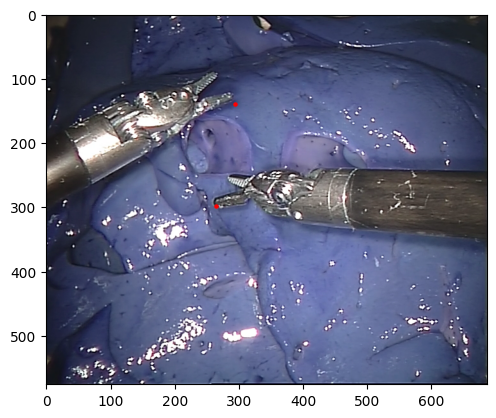

In [16]:
for idx in tqdm(range(len(frames))):
    showTips(frames, idx)